In [117]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [118]:

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, confusion_matrix, ConfusionMatrixDisplay)
from sklearn.feature_selection import chi2, SelectKBest


In [119]:
df = pd.read_csv("https://raw.githubusercontent.com/4GeeksAcademy/logistic-regression-project-tutorial/main/bank-marketing-campaign-data.csv", sep = ";")
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [120]:
print("Tamaño del dataset:", df.shape)

Tamaño del dataset: (41188, 21)


In [121]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

In [122]:
print("\nValores nulos por columna:")
print(df.isnull().sum())


Valores nulos por columna:
age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
duration          0
campaign          0
pdays             0
previous          0
poutcome          0
emp.var.rate      0
cons.price.idx    0
cons.conf.idx     0
euribor3m         0
nr.employed       0
y                 0
dtype: int64


No tenemos datos nulos en nuestro dataset.


--- Distribución de la variable objetivo ---
y
no     0.887346
yes    0.112654
Name: proportion, dtype: float64


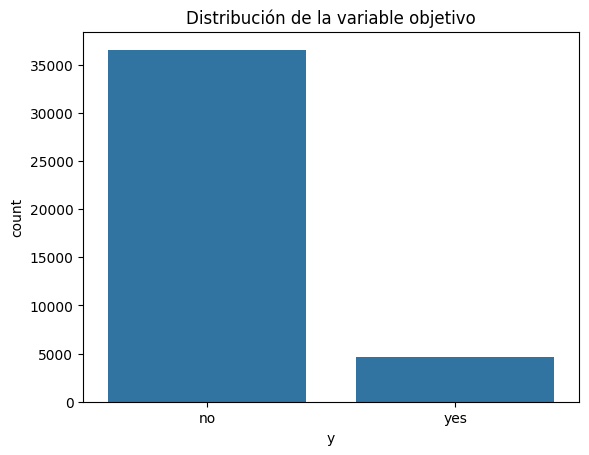

In [123]:
print("\n--- Distribución de la variable objetivo ---")
print(df['y'].value_counts(normalize=True))
sns.countplot(data=df, x='y')
plt.title("Distribución de la variable objetivo")
plt.show()

La variable objetivo en este proyecto es y, que indica si un cliente ha contratado o no un depósito a largo plazo después de la campaña de marketing.

Es una variable categórica.


Ese bloque de código te dará una visión clara de:

Cuántos clientes contrataron (yes) o no contrataron (no) un depósito a largo plazo.

En la  gráfica de barras vemos que la clase no es mucho más alta que yes, lo que indica un desequilibrio de clases (solo ~12% de clientes contrataron el depósito).

Este desequilibrio es importante, ya que puede afectar al rendimiento del modelo.

In [124]:
# Análisis de outliers 
print("\n--- Análisis de outliers por variable numérica ---")

numerical_cols_outliers = [
    'age', 'campaign', 'previous', 'emp.var.rate',
    'cons.price.idx', 'cons.conf.idx', 'euribor3m',
    'nr.employed'
]

for col in numerical_cols_outliers:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
    print(f"{col}: {len(outliers)} outliers")


--- Análisis de outliers por variable numérica ---
age: 469 outliers
campaign: 2406 outliers
previous: 5625 outliers
emp.var.rate: 0 outliers
cons.price.idx: 0 outliers
cons.conf.idx: 447 outliers
euribor3m: 0 outliers
nr.employed: 0 outliers


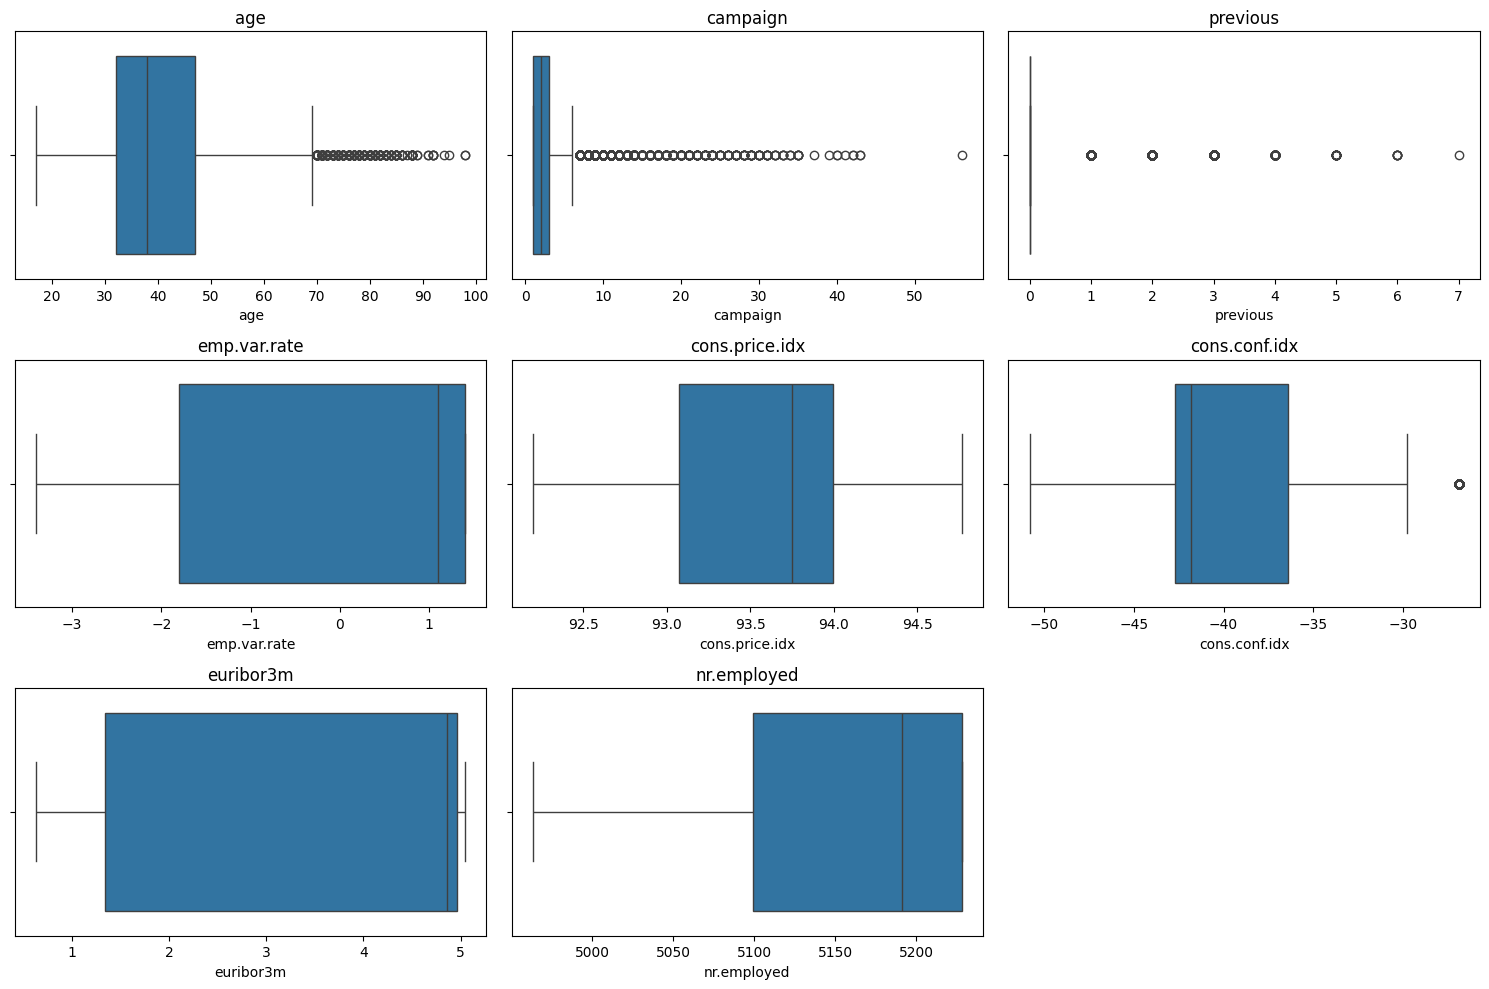

In [125]:
# Visualización de ouliers con boxplots
plt.figure(figsize=(15, 10))
for i, col in enumerate(numerical_cols_outliers):
    plt.subplot(3, 3, i+1)
    sns.boxplot(x=df[col])
    plt.title(col)
plt.tight_layout()
plt.show()


**Análisis de Outliers:**. 

**age:**  
Se observan bastantes outliers por encima de los 70 años.  
Pero la edad avanzada es realista y relevante para el producto financiero.   
Decisión: mantener los outliers.  

**campaign:**.   
Muchos valores extremos. Algunas personas fueron contactadas más de 30 o 40 veces.
Podrían ser errores o casos extremos poco útiles para el modelo.  
Decisión: capar el valor máximo a 15   

**previous:**  
Aparecen outliers con valores hasta 7. La mayoría de los valores están entre 0 y 1.  
Decisión: agrupamos como:  
0 contactos anteriores.  
1  
2 o más

In [126]:
df['campaign'] = np.where(df['campaign'] > 15, 15, df['campaign'])
df['previous'] = df['previous'].apply(lambda x: 2 if x >= 2 else x)

In [127]:
# Eliminar la columna 'duration' (no disponible antes de llamar al cliente)
df = df.drop(columns=['duration'])

In [128]:
#Crear variable binaria si fue contactado antes o no (a partir de 'pdays')
df['was_previously_contacted'] = df['pdays'].apply(lambda x: 0 if x == 999 else 1)
df = df.drop(columns=['pdays'])  # Eliminamos pdays original

In [129]:
#Convierte la variable objetivo (string) y a binaria (y_n)(numérica)
df['y_n'] = df['y'].map({'yes': 1, 'no': 0})
df = df.drop(columns=['y'])

In [130]:
# Definir columnas
categorical_cols = [
    'job', 'marital', 'education', 'default', 'housing', 'loan',
    'contact', 'month', 'day_of_week', 'poutcome'
]
numerical_cols = [
    'age', 'campaign', 'previous', 'emp.var.rate',
    'cons.price.idx', 'cons.conf.idx', 'euribor3m',
    'nr.employed', 'was_previously_contacted'
]

In [131]:
# Escalar variables categóricas 
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
encoded_cat = encoder.fit_transform(df[categorical_cols])
encoded_cat_df = pd.DataFrame(encoded_cat, columns=encoder.get_feature_names_out(categorical_cols))

In [132]:
# Escalar variables numéricas
scaler = MinMaxScaler()
scaled_num = scaler.fit_transform(df[numerical_cols])
scaled_num_df = pd.DataFrame(scaled_num, columns=numerical_cols)


In [133]:
# Dataset final
df_processed = pd.concat([scaled_num_df, encoded_cat_df], axis=1)
df_processed['y_n'] = df['y_n'].values

In [134]:
# Guardar dataset completo procesado
os.makedirs("data/processed", exist_ok=True)
df_processed.to_csv("data/processed/total_data_scaled.csv", index=False)

In [135]:
# División en train / validación / test
# 10% test. Del 90% restante: 20% validación, 80% entrenamiento
X = df_processed.drop(columns=['y_n'])
y = df_processed['y_n']

In [136]:
# Primero train+val y test
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.1, random_state=42, stratify=y)

In [137]:
# Luego de train+val sacamos validación
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.2, random_state=42, stratify=y_temp)

In [142]:
# Modelado con todas las variables
model_all_base = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)
model_all_base.fit(X_train, y_train)
y_pred_all_base = model_all_base.predict(X_test)

In [143]:
# Selección de variables con chi2
selector = SelectKBest(chi2, k=5)
selector.fit(X_train, y_train)
selected_columns = X_train.columns[selector.get_support()]

X_train_sel = pd.DataFrame(selector.transform(X_train), columns=selected_columns)
X_test_sel = pd.DataFrame(selector.transform(X_test), columns=selected_columns)
X_train_sel['y_n'] = y_train.values
X_test_sel['y_n'] = y_test.values

X_train_sel.to_csv("data/processed/clean_train.csv", index=False)
X_test_sel.to_csv("data/processed/clean_test.csv", index=False)


In [144]:
selected_columns = X_train.columns[selector.get_support()]
print("\n Las 5 variables seleccionadas con chi² son:")
print(list(selected_columns))


 Las 5 variables seleccionadas con chi² son:
['previous', 'euribor3m', 'was_previously_contacted', 'month_mar', 'poutcome_success']


In [145]:
# Modelo con solo 5 variables
X_train_small = X_train_sel.drop(columns=['y_n'])
y_train_small = X_train_sel['y_n']
X_test_small = X_test_sel.drop(columns=['y_n'])
y_test_small = X_test_sel['y_n']

model_sel = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)
model_sel.fit(X_train_small, y_train_small)
y_pred_sel = model_sel.predict(X_test_small)

In [146]:
# Optimización del modelo con GridSearchCV
from sklearn.model_selection import GridSearchCV

param_grid = {
    'C': [0.01, 0.1, 1, 10],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear'],
    'class_weight': ['balanced']
}

grid_search = GridSearchCV(LogisticRegression(max_iter=1000, random_state=42),
                           param_grid,
                           cv=5,
                           scoring='f1',
                           verbose=1)
grid_search.fit(X_train, y_train)

model_all = grid_search.best_estimator_
y_pred_all = model_all.predict(X_test)

print("Mejores hiperparámetros encontrados:")
print(grid_search.best_params_)
print("Mejor F1-score en validación cruzada:", grid_search.best_score_)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Mejores hiperparámetros encontrados:
{'C': 10, 'class_weight': 'balanced', 'penalty': 'l1', 'solver': 'liblinear'}
Mejor F1-score en validación cruzada: 0.44729497443902916


In [147]:
# Comparación de modelos
def get_metrics(y_true, y_pred, model_name):
    return {
        'Modelo': model_name,
        'Accuracy': accuracy_score(y_true, y_pred),
        'Precision (Yes)': precision_score(y_true, y_pred),
        'Recall (Yes)': recall_score(y_true, y_pred),
        'F1-score (Yes)': f1_score(y_true, y_pred)
    }

metrics_all_base = get_metrics(y_test, y_pred_all_base, "Modelo base")
metrics_all = get_metrics(y_test, y_pred_all, "Modelo optimizado")
metrics_sel = get_metrics(y_test_small, y_pred_sel, "5 mejores variables")
comparison_df = pd.DataFrame([metrics_all_base, metrics_all, metrics_sel])

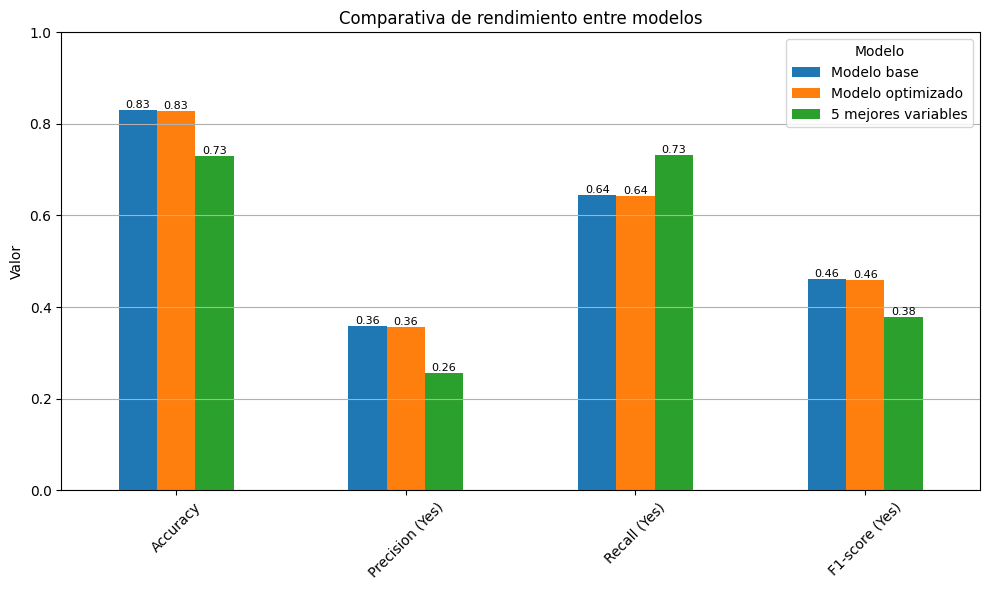

                Modelo  Accuracy  Precision (Yes)  Recall (Yes)  \
0          Modelo base  0.829813         0.358084      0.644397   
1    Modelo optimizado  0.828842         0.356033      0.642241   
2  5 mejores variables  0.729789         0.255831      0.732759   

   F1-score (Yes)  
0        0.460354  
1        0.458109  
2        0.379253  


In [148]:
# Visualizar comparación
ax = comparison_df.set_index("Modelo").T.plot(kind="bar", figsize=(10, 6))
plt.title("Comparativa de rendimiento entre modelos")
plt.ylabel("Valor")
plt.ylim(0, 1)
plt.grid(True, axis='y')
plt.xticks(rotation=45)

# Añadir etiquetas de valor en cada barra
for container in ax.containers:
    ax.bar_label(container, fmt='%.2f', label_type='edge', fontsize=8)

plt.tight_layout()
plt.show()

print(comparison_df)

**CONCLUSIÓN DE LA COMPARATIVA DE MODELOS:**

Se han comparado tres enfoques para predecir si un cliente contratará un depósito a largo plazo:

1. MODELO BASE:
   - Incluye todas las variables.
   - Buen equilibrio entre precisión (0.36) y recall (0.64).
   - F1-score: 0.46
   - Recomendado para campañas generales donde se busca eficiencia sin perder demasiado recall.

2. MODELO OPTIMIZADO:
   - Hiperparámetros ajustados con GridSearchCV.
   - Resultados muy similares al modelo base.
   - Mejor F1 en validación cruzada, pero sin mejoras notables en test.
   - Útil si se quiere validar robustez del modelo.

3. MODELO REDUCIDO (5 MEJORES VARIABLES):
   - Menor precisión (0.26), pero mayor recall (0.73).
   - F1-score más bajo (0.38).
   - Ideal si el objetivo es NO perder clientes potenciales aunque se asuman más falsos positivos.

CONCLUSIÓN FINAL:
- El modelo base es el más equilibrado y eficiente para uso general.
- El modelo optimizado no mejora sustancialmente.
- El modelo reducido puede usarse en campañas muy agresivas donde importa más no perder oportunidades que evitar errores.